In [9]:
from typing import Sequence
import torchsde
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal
import math  

class Morris_Lecar(object):
    noise_type = "diagonal"
    sde_type = "ito"
    
    def __init__(self, a, b):
        super(Morris_Lecar, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        V, omega, eta = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        phi, C, gca, Vca, gk, Vk, gL, VL, V1, V3, V2, V4, Iapp, nu = self.a
        
        f1 = (1/C) * (-gca*self.m_inf(V,V1,V2)*(V-Vca)-gk*omega*(V-VL)-gL*(V-VL)+Iapp+eta)
        f2 = (1/self.tau(V,V3,V4,phi))*(self.o_inf(V,V3,V4)-omega)
        f3 = -nu*eta
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        V, omega, eta = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = b1 + 0.0*V
        g2 = b2 + 0.0*omega
        g3 = b3 + 0.0*eta
        return torch.cat([g1, g2, g3], dim=1)

    def m_inf(self,V,V1,V2):
        return (1+torch.tanh((V-V1)/V2))/2
    
    def o_inf(self,V,V3,V4):
        return (1+torch.tanh((V-V3)/V4))/2    

    def tau(self,V,V3,V4,phi):
        return phi*(1/torch.cosh((V-V3)/(2*V4)))  
    
    @torch.no_grad()
    def sample(self, x0, ts):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts, method='srk')#,adaptive=True)
        return xs

In [10]:
batch_size, state_size, t_size = 10, 3, 10**3
tf=5
#parameters
phi=0.3333
C=1 
gca=1.33
Vca=1
gk=2
Vk=-0.7
gL=0.5
VL=-0.5
V1=-0.01
V3=0.1
V2=0.15
V4=0.145
Iapp=0.07
nu=1
sigma=0.02
p=(phi,C,gca,Vca,gk,Vk,gL,VL,V1,V3,V2,V4,Iapp,nu)

y0 = torch.tensor([-.5, -.5, 0.0])*torch.ones(batch_size, state_size, device='cpu') \
     + 0.001*torch.rand(batch_size, state_size, device='cpu') 
ts = torch.linspace(0, tf, t_size, device='cpu')
xs = Morris_Lecar(a=p,b = (0.0, 0.0, sigma)).sample(y0, ts)
x1=xs[:,:,0]
x2=xs[:,:,1]
x3=xs[:,:,2]
#plt.plot(ts.cpu().detach().numpy(),x1.cpu().detach().numpy())

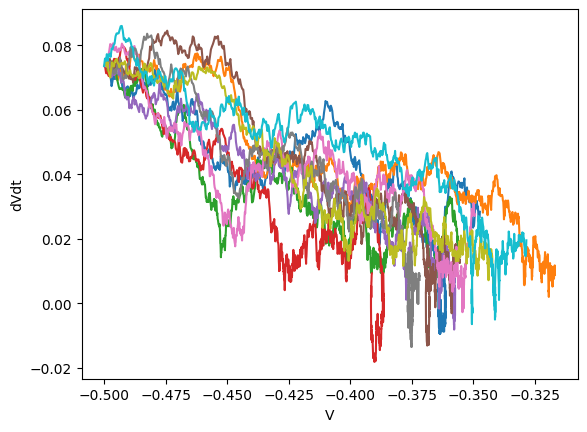

In [11]:
def m_i(V,V1,V2):
    return (1+torch.tanh((V-V1)/V2))/2
dvdt= (1/C) * (-gca*m_i(x1,V1,V2)*(x1-Vca)-gk*x2*(x1-VL)-gL*(x1-VL)+Iapp+x3)
#plt.plot(x1,dvdt)
plt.plot(x1,dvdt)
plt.ylabel('dVdt')
plt.xlabel('V')
plt.show()

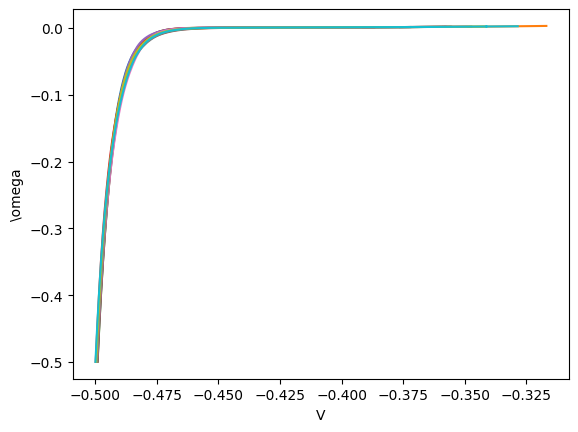

In [12]:
plt.plot(x1,x2)
plt.ylabel('\omega')
plt.xlabel('V')
plt.show()